# Classification CAH

In this notebook, the data with 100000 flights is used to conduct the classification.

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.ensemble import GradientBoostingClassifier
from pretreatment import *
from cluster import *

In [81]:
database_name = 'descriptors_last.db'

columns_dropped = ['icao', 'icao_airline', 'duration_cruise', 'airport_climb', 'airport_descent']

df, df_meteo, df_operation, airlines_decoder = pretreatment(database_name, columns_dropped, threshold_nb_flights=100, drop_min_max=True)
columns = df.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df, n_estimators=100)
columns_remained = feature_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns, begin=-3, end=3, n_choices=10)

number of evaluation is 1
number of evaluation is 2
number of evaluation is 3
number of evaluation is 4
number of evaluation is 5


In [82]:
columns_meteo = df_meteo.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df_meteo, n_estimators=100)
columns_remained_meteo = feature_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns_meteo, begin=-3, end=3, n_choices=10)

number of evaluation is 1


In [83]:
columns_operation = df_operation.columns
mad, clf, accuracy, X_train, X_test, y_train, y_test = feature_selection_baseline(df_operation, n_estimators=100)
columns_remained_operation = feature_selection(mad, clf, accuracy, X_train, X_test, y_train, y_test, columns_operation, begin=-3, end=3, n_choices=10)

number of evaluation is 1
number of evaluation is 2
number of evaluation is 3


In [86]:
print(f'Columns deleted for whole dataset: {columns_deleted(columns, columns_remained)}')
print(f'Columns deleted for meteo sub dataset: {columns_deleted(columns_meteo, columns_remained_meteo)}')
print(f'Columns deleted for meteo sub dataset: {columns_deleted(columns_operation, columns_remained_operation)}')

Columns deleted for whole dataset: ['std_vertrate_speed_cruise', 'std_altitude_cruise', 'wind_spind_kt_climb', 'std_speed_descent', 'duration_climb', 'avg_speed_descent', 'avg_vertrate_speed_cruise', 'wind_spind_kt_descent']
Columns deleted for meteo sub dataset: ['wind_spind_kt_climb', 'wind_spind_kt_descent']
Columns deleted for meteo sub dataset: ['std_altitude_cruise', 'avg_vertrate_speed_cruise', 'duration_climb']


# Aggregating data

In [89]:
df_airlines = to_airlines(df, columns_remained)
df_airlines_meteo = to_airlines(df_meteo, columns_remained_meteo)
df_airlines_operation = to_airlines(df_operation, columns_remained_operation)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

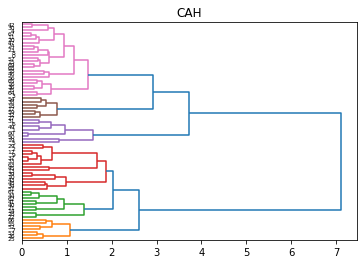

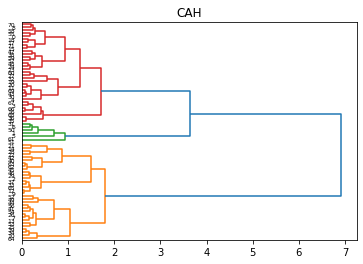

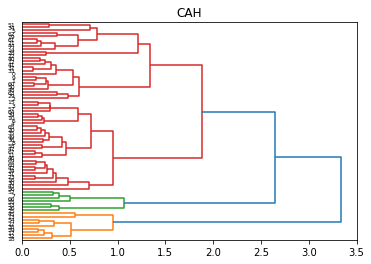

In [10]:
groups_cah = cah(df_airlines)
groups_cah_meteo = cah(df_airlines_meteo)
groups_cah_operation = cah(df_airlines_operation)

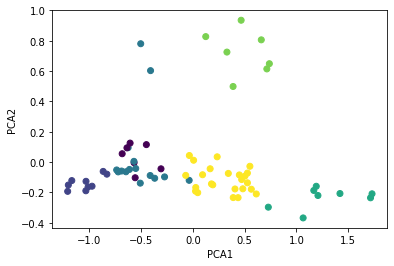

In [18]:
pca_plot_clustering(df_airlines,groups_cah)

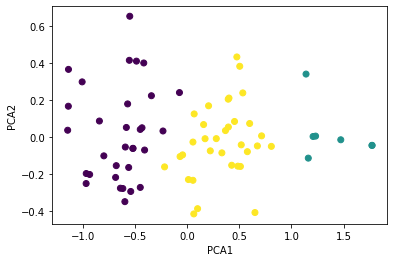

In [19]:
pca_plot_clustering(df_airlines_meteo,groups_cah_meteo)

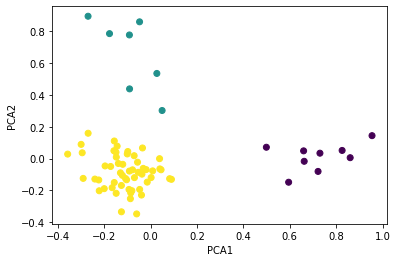

In [20]:
pca_plot_clustering(df_airlines_operation, groups_cah_operation)

In [21]:
group_descriptors(df_airlines, groups_cah)

,dewpoint_c_climb,dewpoint_c_descent,temp_c_climb,temp_c_descent,std_altitude_cruise,avg_vertrate_speed_cruise,std_speed_cruise,std_vertrate_speed_descent,wind_spind_kt_descent,wind_spind_kt_climb,...,avg_vertrate_speed_descent,duration_climb,std_speed_climb,avg_vertrate_speed_climb,mean_altitude_cruise,avg_speed_descent,std_vertrate_speed_climb,std_speed_descent,avg_speed_climb,avg_speed_cruise
group,,,,,,,,,,,,,,,,,,,,,
1,15.0,14.00,20.0,21.0,5.300797,5.090942e-02,5.183573,2.322618,7.0,6.0,...,-5.198526,1000.0,38.075776,8.567895,9784.767457,150.456812,4.031140,51.583234,182.782857,241.661500
2,20.0,19.00,27.0,27.0,4.785592,0.000000e+00,1.491106,3.795597,7.0,5.0,...,-7.133675,1139.5,42.877201,8.900034,10972.461333,154.783111,3.807397,50.431853,192.919588,232.657655
3,14.0,13.00,22.0,22.0,4.557814,0.000000e+00,2.489591,3.550138,5.0,5.0,...,-6.575059,1291.0,40.313521,8.514119,10969.457895,160.011968,4.094133,52.468353,198.951833,231.669473
4,-11.0,-8.75,-4.0,-5.0,5.414072,0.000000e+00,2.804788,3.304762,8.0,8.0,...,-6.407472,1120.0,45.589540,8.967112,10971.564223,147.983819,3.912773,51.150246,190.085806,229.396783
5,0.6,0.60,10.0,11.7,163.976599,-1.881734e-18,6.220388,3.709823,8.0,7.0,...,-6.861570,1199.0,40.773496,8.432621,10973.152101,164.491662,4.144348,57.284864,196.573841,234.115954
6,3.0,3.00,9.0,9.5,6.744597,0.000000e+00,2.860498,3.922489,7.0,6.5,...,-7.124372,1062.5,44.059310,9.970382,11278.438200,162.606177,4.376518,51.711924,188.177024,224.866207


In [23]:
group_descriptors(df_airlines_meteo, groups_cah_meteo)

,dewpoint_c_climb,dewpoint_c_descent,temp_c_climb,temp_c_descent,wind_spind_kt_climb,wind_spind_kt_descent
group,,,,,,
1,14.5,14.0,22.0,22.0,6.0,6.75
2,-11.0,-9.5,-5.0,-6.0,8.0,8.00
3,2.0,2.0,9.0,10.0,7.0,7.00


In [24]:
group_descriptors(df_airlines_operation, groups_cah_operation)

,std_altitude_cruise,avg_vertrate_speed_cruise,std_speed_cruise,std_vertrate_speed_descent,avg_vertrate_speed_descent,duration_climb,std_vertrate_speed_cruise,duration_descent,mean_altitude_cruise,std_speed_climb,avg_speed_descent,avg_vertrate_speed_climb,avg_speed_climb,avg_speed_cruise,std_speed_descent,std_vertrate_speed_climb
group,,,,,,,,,,,,,,,,
1,163.976599,0.000000,5.991034,3.709823,-6.896681,1250.0,0.228779,1720.0,10953.467778,41.429617,163.825340,8.274343,196.670000,234.115954,53.964040,4.089771
2,5.300797,0.050909,5.183573,2.322618,-5.198526,1000.0,0.188965,1750.0,9784.767457,38.075776,150.456812,8.567895,182.782857,241.661500,51.583234,4.031140
3,5.585779,0.000000,2.472795,3.612242,-7.014410,1125.0,0.220675,1540.0,10973.304828,43.376483,160.898130,9.227651,190.452672,229.190000,51.922130,4.106570


In [56]:
classification = airlines_group(df_airlines, groups_cah, airlines_decoder)
classification.reset_index(inplace=True)
classification.columns = ['group', 'airline']
classification

,group,airline
0,1,China Eastern Airlines
1,1,Shenzhen Airlines
2,1,Sichuan Airlines
3,1,West Air (China)
4,1,China Southern Airlines
...,...,...
65,6,Iberia Airlines
66,6,Iberia Express
67,6,Lufthansa
68,6,British Airways Shuttle


In [57]:
classification_meteo = airlines_group(df_airlines_meteo, groups_cah_meteo, airlines_decoder)
classification_meteo.reset_index(inplace=True)
classification_meteo.columns = ['group_meteo', 'airline']
classification_meteo

,group_meteo,airline
0,1,Qatar Airways
1,1,LATAM Peru
2,1,Avianca
3,1,Batik Air
4,1,LATAM Chile
...,...,...
67,3,Iberia Express
68,3,JetBlue Airways
69,3,Lufthansa
70,3,Pegasus Airlines


In [58]:
classification_operation = airlines_group(df_airlines_operation, groups_cah_operation, airlines_decoder)
classification_operation.reset_index(inplace = True)
classification_operation.columns = ['group_operation', 'airline']
classification_operation

,group_operation,airline
0,1,JetBlue Airways
1,1,Frontier Airlines
2,1,Pakistan International Airlines
3,1,Delta Air Lines
4,1,American Airlines
...,...,...
65,3,GoAir
66,3,easyJet Europe
67,3,Iberia Airlines
68,3,IndiGo Airlines


In [66]:
classification_3 = classification.merge(classification_meteo, how='left', on='airline').merge(classification_operation, how='left', on='airline')
cols = ["airline", "group", "group_meteo", "group_operation"]
classification_3[cols]

,airline,group,group_meteo,group_operation
0,China Eastern Airlines,1,1,2
1,Shenzhen Airlines,1,1,2
2,Sichuan Airlines,1,1,2
3,West Air (China),1,3,2
4,China Southern Airlines,1,1,2
...,...,...,...,...
65,Iberia Airlines,6,3,3
66,Iberia Express,6,3,3
67,Lufthansa,6,3,3
68,British Airways Shuttle,6,3,3


In [26]:
# inertia curve to determine optimal number of clusters with elbow method
inertias=[]
for k in range(1,15):
    kmeans = KMeans(n_clusters=k).fit(df_median_scaled)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,15),inertias)

NameError: name 'df_median_scaled' is not defined

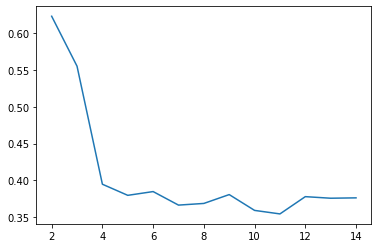

In [74]:
# silhouette curve to determine optimal number of cluster for highest silhouette score
from sklearn.metrics import silhouette_score
silhouettes=[]
for k in range(2,15):
    kmeans = KMeans(n_clusters=k).fit(df_airlines_operation)
    silhouettes.append(silhouette_score(df_airlines_operation,kmeans.labels_))
plt.plot(range(2,15),silhouettes)

In [194]:
# sort the result by the importance of features
importance_column = 
with open('classification_stats_importance.csv', 'w') as f:
    f.write(importance_column.to_csv())

,std_altitude_cruise,avg_vertrate_speed_cruise,std_speed_cruise,std_vertrate_speed_descent,std_vertrate_speed_cruise,avg_vertrate_speed_descent,duration_climb,mean_altitude_cruise,avg_vertrate_speed_climb,duration_descent,std_speed_climb,avg_speed_descent,std_vertrate_speed_climb,avg_speed_climb,avg_speed_cruise,std_speed_descent
group,,,,,,,,,,,,,,,,
1,168.912173,-0.000037,5.839012,3.706753,0.226017,-6.873351,1220.0,11034.156365,8.421344,1655.0,41.916626,162.664291,4.034074,197.021390,233.734178,53.337206
2,5.097527,0.048801,5.183573,2.278364,0.188580,-5.206875,1000.0,9784.556250,8.636699,1739.5,39.485181,151.148334,4.067120,182.961260,236.825596,51.956242
3,6.688130,0.000000,3.102418,3.934636,0.249860,-7.112391,1064.5,11270.021152,9.696522,1550.0,45.258765,161.511544,4.299688,189.572335,224.726929,52.912215
4,4.332675,0.000000,1.960683,3.494997,0.175654,-6.447822,1245.0,10970.900776,8.585675,1575.0,42.113074,152.238226,3.850046,193.481036,232.107106,50.902117


In [195]:
with open('classification.csv','w') as f:
    f.write(classif.to_csv())

,airline_cat,0
1,88,Frontier Airlines
1,77,Delta Air Lines
1,130,Pakistan International Airlines
1,181,United Airlines
1,43,American Airlines
1,42,Allegiant Air
1,36,Airblue
1,156,Spirit Airlines
2,69,China Southern Airlines
2,67,China Eastern Airlines
